In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
db_path = "wildfiredata.sqlite"  # SQLite 파일 경로
chunksize = 100_000  # 한 번에 읽을 행 수

con = sqlite3.connect(db_path)

In [3]:
# 먼저 테이블 컬럼 정보 확인
columns_info = pd.read_sql_query("PRAGMA table_info(Fires);", con)
print("📌 Fires 테이블 컬럼 구조")
print(columns_info)

📌 Fires 테이블 컬럼 구조
    cid                        name       type  notnull dflt_value  pk
0     0                    OBJECTID    INTEGER        1       None   1
1     1                      FOD_ID      int32        0       None   0
2     2                      FPA_ID  text(100)        0       None   0
3     3          SOURCE_SYSTEM_TYPE  text(255)        0       None   0
4     4               SOURCE_SYSTEM   text(30)        0       None   0
5     5       NWCG_REPORTING_AGENCY  text(255)        0       None   0
6     6      NWCG_REPORTING_UNIT_ID  text(255)        0       None   0
7     7    NWCG_REPORTING_UNIT_NAME  text(255)        0       None   0
8     8       SOURCE_REPORTING_UNIT   text(30)        0       None   0
9     9  SOURCE_REPORTING_UNIT_NAME  text(255)        0       None   0
10   10        LOCAL_FIRE_REPORT_ID  text(255)        0       None   0
11   11           LOCAL_INCIDENT_ID  text(255)        0       None   0
12   12                   FIRE_CODE   text(10)        0    

In [5]:
# 결측치 카운트 저장용
null_counts = None
total_rows = 0

# 수치형 분포 저장용 (히스토그램)
numeric_data = {}

In [6]:
# 청크 단위로 순회
for chunk in pd.read_sql_query("SELECT * FROM Fires", con, chunksize=chunksize):
    total_rows += len(chunk)
    
    # 결측치 카운트 누적
    chunk_nulls = chunk.isna().sum()
    if null_counts is None:
        null_counts = chunk_nulls
    else:
        null_counts += chunk_nulls
    
    # 수치형 데이터 누적 (히스토그램)
    for col in chunk.select_dtypes(include='number').columns:
        if col not in numeric_data:
            numeric_data[col] = []
        numeric_data[col].extend(chunk[col].dropna().tolist())

In [7]:
con.close()

In [8]:
# 결측치 비율 계산
missing_rate = (null_counts / total_rows) * 100
print("\n📌 결측치 비율(%)")
print(missing_rate.sort_values(ascending=False))


📌 결측치 비율(%)
COMPLEX_NAME                  99.724377
MTBS_FIRE_NAME                99.414879
MTBS_ID                       99.414879
ICS_209_NAME                  98.632413
ICS_209_INCIDENT_NUMBER       98.632413
FIRE_CODE                     82.726134
LOCAL_FIRE_REPORT_ID          77.602402
CONT_TIME                     51.698543
FIRE_NAME                     50.901718
CONT_DATE                     47.410135
CONT_DOY                      47.410135
DISCOVERY_TIME                46.937220
LOCAL_INCIDENT_ID             43.649895
COUNTY                        36.062782
FIPS_CODE                     36.062782
FIPS_NAME                     36.062782
LATITUDE                       0.000000
LONGITUDE                      0.000000
OWNER_CODE                     0.000000
OWNER_DESCR                    0.000000
STATE                          0.000000
FIRE_SIZE_CLASS                0.000000
FIRE_SIZE                      0.000000
OBJECTID                       0.000000
FIRE_YEAR                  

In [9]:
# 간단 통계량 (수치형 컬럼만)
numeric_df = pd.DataFrame({col: pd.Series(vals) for col, vals in numeric_data.items()})
print("\n📌 기본 통계량 (수치형만)")
print(numeric_df.describe())


📌 기본 통계량 (수치형만)
           OBJECTID        FOD_ID     FIRE_YEAR  DISCOVERY_DATE  \
count  1.880465e+06  1.880465e+06  1.880465e+06    1.880465e+06   
mean   9.402330e+05  5.484020e+07  2.003710e+03    2.453064e+06   
std    5.428436e+05  1.011963e+08  6.663099e+00    2.434573e+03   
min    1.000000e+00  1.000000e+00  1.992000e+03    2.448622e+06   
25%    4.701170e+05  5.055000e+05  1.998000e+03    2.451084e+06   
50%    9.402330e+05  1.067761e+06  2.004000e+03    2.453178e+06   
75%    1.410349e+06  1.910639e+07  2.009000e+03    2.455036e+06   
max    1.880465e+06  3.003484e+08  2.015000e+03    2.457388e+06   

       DISCOVERY_DOY  STAT_CAUSE_CODE     CONT_DATE       CONT_DOY  \
count   1.880465e+06     1.880465e+06  9.889340e+05  988934.000000   
mean    1.647191e+02     5.979037e+00  2.453238e+06     172.656766   
std     9.003891e+01     3.483860e+00  2.687548e+03      84.320348   
min     1.000000e+00     1.000000e+00  2.448622e+06       1.000000   
25%     8.900000e+01     3.00

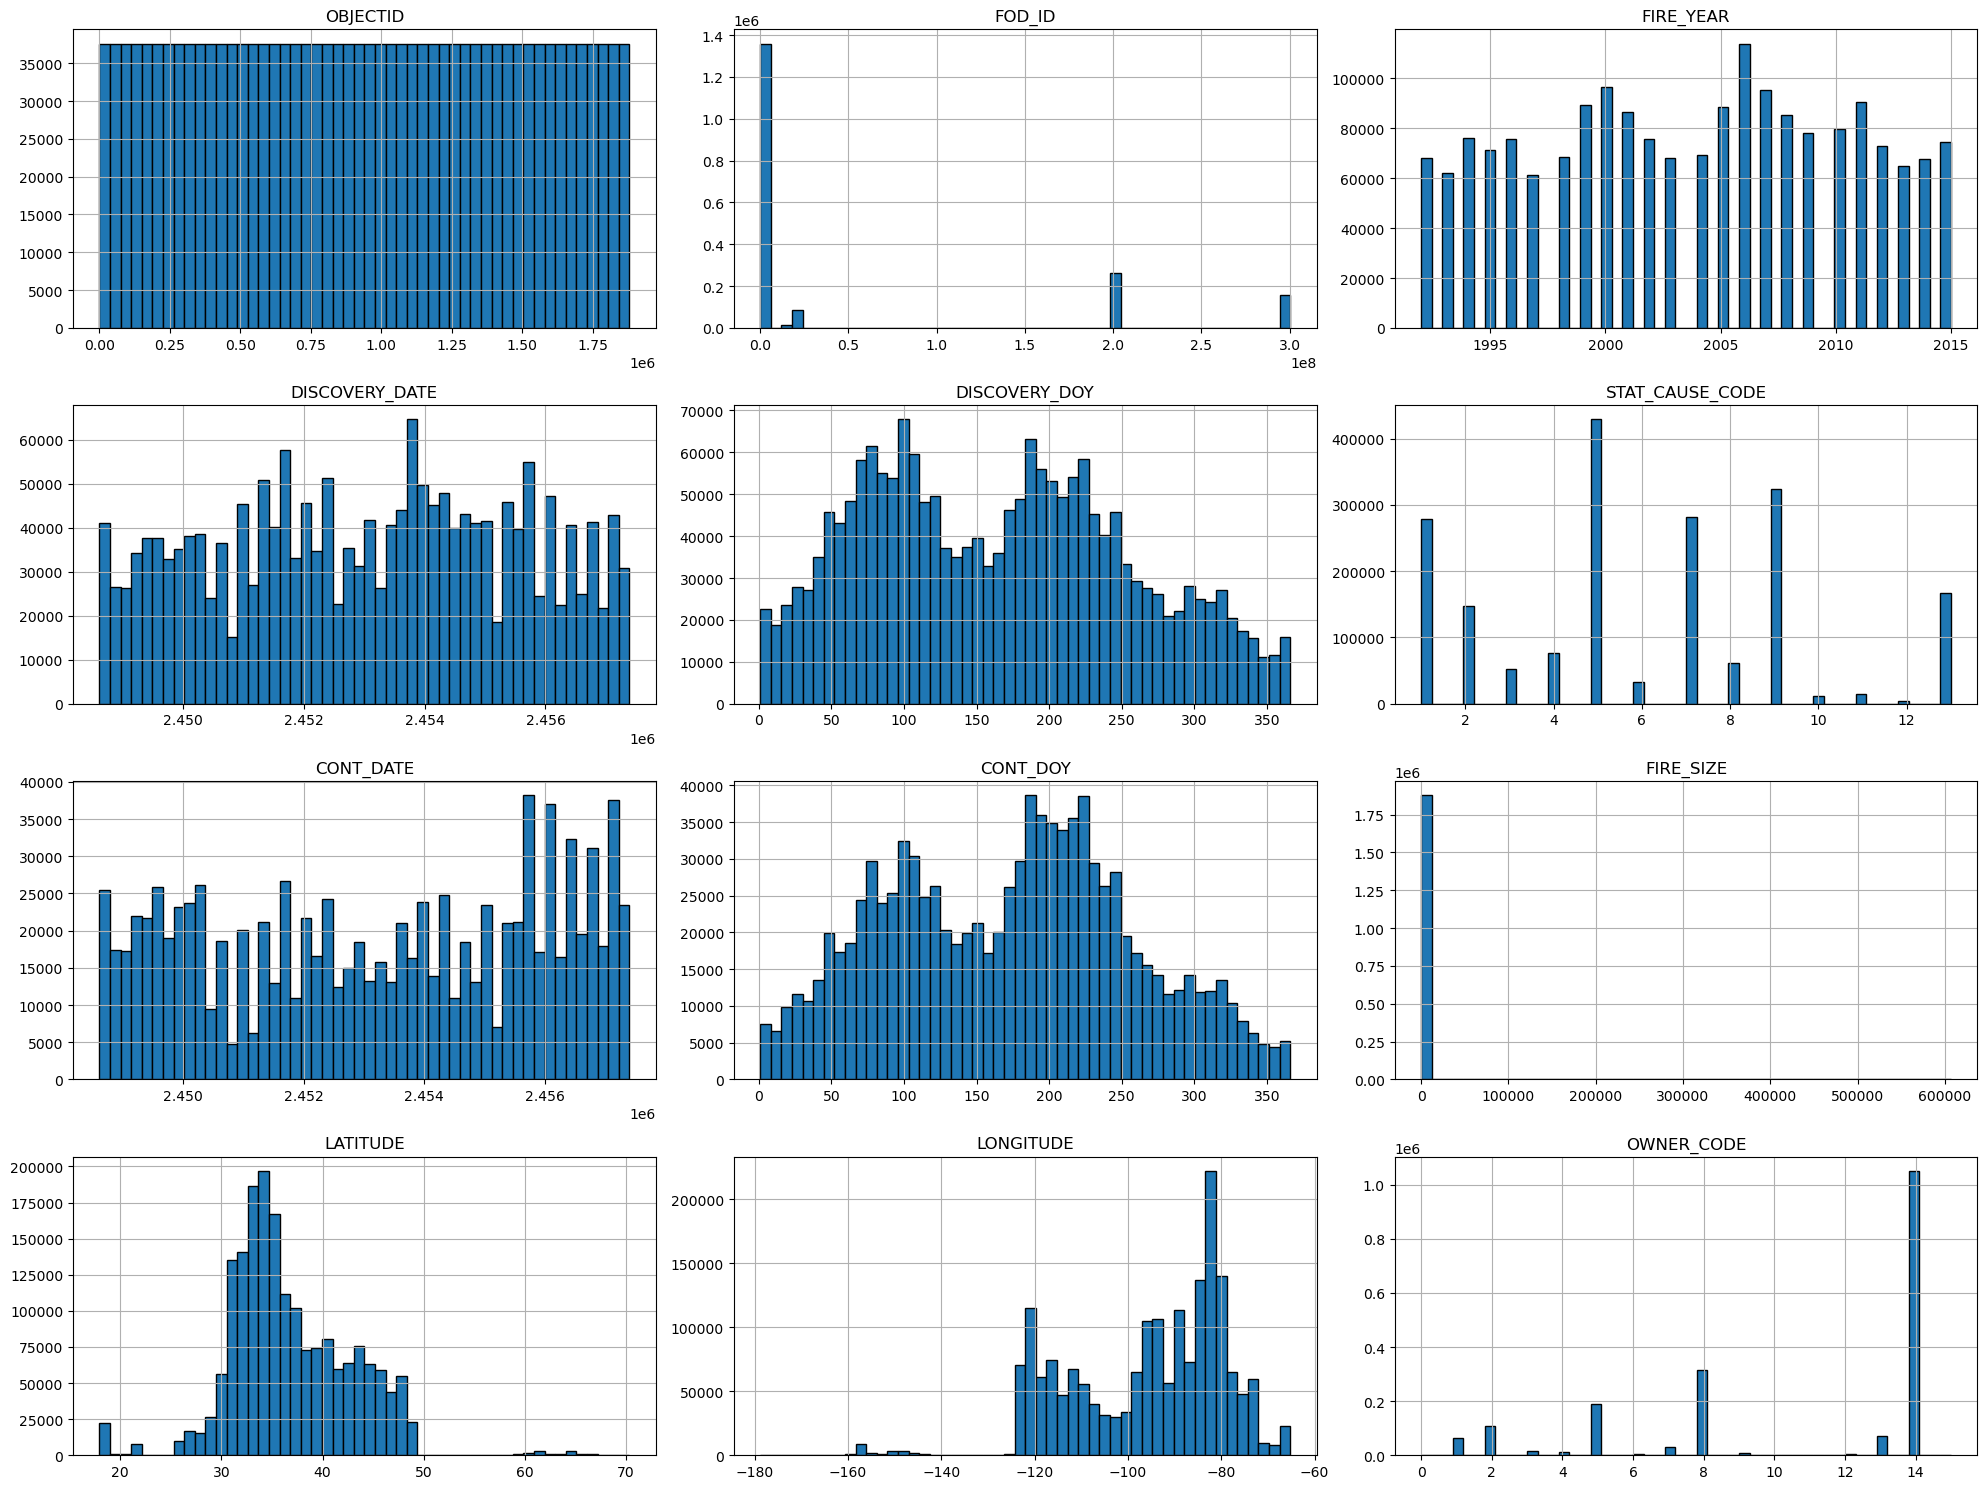

In [10]:
# 히스토그램 시각화
numeric_df.hist(bins=50, figsize=(20, 15), edgecolor='black')
plt.tight_layout()
plt.show()